In [1]:
import glob
from sklearn.model_selection import train_test_split
from Metrics.FourierAnalysisMaster.pspec import rgb_2_darter
import cv2
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras as K
import pandas as pd
import seaborn as sns

# Preparing the habitat data

listing the environment images

In [2]:
HAB_SPECIE = "blennioides"

habitat_path = glob.glob("../Images/HAB/{}/*/*.tiff".format(HAB_SPECIE))
print(len(habitat_path))

274


preprocessing the images by resizing them, and transforming them into the darter luminance space, then normalizing

In [3]:
def preprocess_habitat_image(image, new_dsize, to_darter=True):
    image = cv2.resize(image, dsize=(new_dsize[::-1]), interpolation=cv2.INTER_CUBIC)
    if to_darter:
        image = rgb_2_darter(image)
        image = image[..., 0]+image[..., 1]
        image = image[..., np.newaxis]
    return image

In [4]:
WIDTH_IMG=600
HEIGHT_IMG=400
CHANNELS_IMG=3

habitat_img = np.empty(shape=(len(habitat_path), HEIGHT_IMG, WIDTH_IMG, CHANNELS_IMG))
for i, path in enumerate(habitat_path):
    img = imageio.imread(path)
    habitat_img[i] = preprocess_habitat_image(img, (HEIGHT_IMG, WIDTH_IMG), CHANNELS_IMG==1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


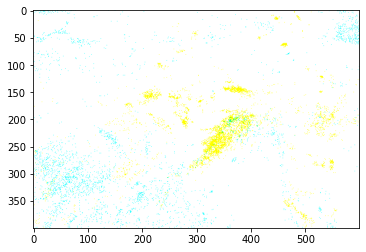

float64


In [5]:
plt.imshow(habitat_img[0], cmap='gray')
plt.show()
print(habitat_img.dtype)

Splitting the data between train and test

In [6]:
print("number of habitat images: ", habitat_img.shape[0])
train, test = train_test_split(habitat_img, train_size=0.8, shuffle=True)
print("train: {}, test: {}".format(train.shape[0], test.shape[0]))

number of habitat images:  274
train: 219, test: 55


Doing data augmentation and normalization

In [7]:
PREDICTION_SIZE = 100

In [10]:
def fly_over_image(image, window=(PREDICTION_SIZE, PREDICTION_SIZE), stride=PREDICTION_SIZE//5, return_coord=False):
    img_Y = image.shape[-2]
    img_X = image.shape[-3]
    for start_x in range(0, img_X-window[0]+1, stride):
        for start_y in range(0, img_Y-window[1]+1, stride):
            if return_coord:
                yield (start_x, start_x+window[0], start_y, start_y+window[1])
            else:
                sample = image[start_x: start_x+window[0], start_y: start_y + window[1]]
                yield sample
            
def mirror(image):
    return [image, np.flip(image, axis=(-2))]

def augment(set_img):
    augmented = []
    for idx, img in enumerate(set_img):
        for sample in fly_over_image(img, (PREDICTION_SIZE, PREDICTION_SIZE), PREDICTION_SIZE):
            augmented += mirror(sample)
    augmented = np.array(augmented)
    return augmented

def normalize(set_img):
    #set_img = (set_img - np.mean(set_img)) / np.std(set_img)
    return (set_img - np.min(set_img)) / (np.max(set_img) - np.min(set_img)) 
    

In [11]:
test = augment(test)
test = normalize(test)

train = augment(train)
train = normalize(train)

print("train: {}, test: {}".format(train.shape[0], test.shape[0]))

train: 10512, test: 5280


# Preparing the Auto encoder

In [12]:
LATENT_DIM=200
BATCH_SIZE=50
EPOCHS=10

model 1

In [ ]:
K.backend.clear_session()

autoencoder = K.Sequential([
    K.layers.Flatten(),
    K.layers.Dense(LATENT_DIM, activation='sigmoid'),
    K.layers.Dense(PREDICTION_SIZE*PREDICTION_SIZE*CHANNELS_IMG , activation='sigmoid'),
    K.layers.Reshape((PREDICTION_SIZE , PREDICTION_SIZE, CHANNELS_IMG ))
])

autoencoder.compile(optimizer='adam', 
                       loss='mse', 
                       metrics=['accuracy', 'mse']
                      )

model 2

In [ ]:
K.backend.clear_session()

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            K.layers.Flatten(),
            K.layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            K.layers.Dense(PREDICTION_SIZE*PREDICTION_SIZE*CHANNELS_IMG, activation='sigmoid'),
            K.layers.Reshape((PREDICTION_SIZE, PREDICTION_SIZE, CHANNELS_IMG))
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(LATENT_DIM)

autoencoder.compile(optimizer='adam', loss='mse')# K.losses.MeanSquaredError())

model 3

In [13]:
K.backend.clear_session()

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            K.layers.Flatten(),
            K.layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            K.layers.Dense(PREDICTION_SIZE*PREDICTION_SIZE*CHANNELS_IMG, activation='sigmoid'),
            K.layers.Reshape((PREDICTION_SIZE, PREDICTION_SIZE, CHANNELS_IMG))
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(LATENT_DIM)

autoencoder.compile(optimizer='adam', loss='mse')# K.losses.MeanSquaredError())

# Training

In [14]:
history = autoencoder.fit(x=train, y=train, 
                            batch_size=BATCH_SIZE, 
                            validation_data=(test, test),
                            epochs= EPOCHS, 
                            callbacks= [],
                            shuffle= True,
                            #steps_per_epoch=200
                            )

Epoch 1/10


InternalError:  Blas GEMM launch failed : a.shape=(50, 30000), b.shape=(30000, 200), m=50, n=200, k=30000
	 [[node autoencoder/sequential/dense/MatMul (defined at <ipython-input-13-ccebc4c79f71>:17) ]] [Op:__inference_train_function_620]

Function call stack:
train_function


In [ ]:
%matplotlib inline
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="val")
plt.legend()
plt.show()

# Visualize Predictions

In [ ]:
sample_test= test[:50]
prediction = autoencoder.predict(sample_test)
print(sample_test.shape, prediction.shape)

In [ ]:
%matplotlib qt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(sample_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(prediction[i])
    plt.title("reconstructed")
    plt.gray()
    mse=K.losses.MSE(sample_test[i], prediction[i])
    #print(mse)
    ax.set_xlabel("mse: {}".format(mse))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Divergence study

### Prepare fish data

In [ ]:
FISH_SPECIE = "barrenense"

male_fish_path = glob.glob("../Images/Crops/{}/*_M*.tif".format(FISH_SPECIE))
female_fish_path = glob.glob("../Images/Crops/{}/*_F*.tif".format(FISH_SPECIE))

print("specie: {} / females: {} / males: {}".format(FISH_SPECIE, len(female_fish_path), len(male_fish_path)))

In [ ]:
def preprocess_fish_image(image):
    image = rgb_2_darter(image)
    image = image[..., 0]+image[..., 1]
    image = (image-np.min(image))/(np.max(image)-np.min(image))
    return image[..., np.newaxis]

### visualize heatmap

In [ ]:
def get_heat_prediction_fish(img):
    heatmap = np.zeros_like(img)
    ponderation = np.ones_like(img)
    batch = []
    for sample in fly_over_image(img, (PREDICTION_SIZE, PREDICTION_SIZE), PREDICTION_SIZE//5, False):
        batch += [sample]
        
    batch = np.array(batch)
    prediction = autoencoder.predict(batch)
    mse=K.losses.MSE(batch, prediction)
    
    i = 0
    for x1, x2, y1, y2 in fly_over_image(img, (PREDICTION_SIZE, PREDICTION_SIZE), PREDICTION_SIZE//5, True):
        heatmap[x1:x2, y1:y2, 0] += mse[i]
        ponderation[x1:x2, y1:y2, 0] += 1
        i+=1
    return np.divide(heatmap, ponderation)

In [ ]:
fishes = []
ht = []

for i, path in enumerate(male_fish_path):
    img = imageio.imread(path)
    fishes += [preprocess_fish_image(img)]
    
for fish in fishes:
    ht += [get_heat_prediction_fish(fish)]


In [ ]:
# %matplotlib qt
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(fishes[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display heatmap
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(ht[i], cmap='hot')
    plt.title("heatmap")
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

### visualize divergence

In [ ]:
def divergence(autoencoder, start, repetition, visu=False):
    if start.ndim==3:
        start=start[np.newaxis, ...]
    prev_decoded = start
    if visu: plt.figure(figsize=(20, 4))
    shift_decoded = []
    for i in range(repetition):
        if visu:
            ax = plt.subplot(repetition//10, 10, i+1)
            plt.imshow(prev_decoded[0])

        new_decoded = autoencoder.predict(prev_decoded)
        prev_decoded = new_decoded#.numpy()
        shift_decoded.append(np.mean(np.square(start - prev_decoded), axis=(-1,-2,-3)))
    if visu: plt.show()
    return shift_decoded 

x = next( fly_over_image(fishes[0], (PREDICTION_SIZE, PREDICTION_SIZE), PREDICTION_SIZE//5, False) )
shift = divergence(autoencoder, x , 50, True)
plt.plot(shift)
plt.show()

In [ ]:
def order_by_divergence(x_test, iteration ,visu=True):
    if x_test.ndim==3:
        x_test=x_test[np.newaxis, ...]
    last_shift=[]
    for i in range(iteration):
        start = x_test[np.newaxis, i]
        shift = divergence(start, iteration)
        plt.plot(shift)
        last_shift.append(shift[-1][0])
    plt.title("MSE divergence through iteration")
    plt.xlabel("iteration")
    plt.ylabel("MSE")
    plt.show()
    return x_test[np.argsort(last_shift)]

# Execute a test for all the fishes

Prepare the dataframes

In [ ]:
data = pd.read_csv("../Results/image_list.csv")
results = pd.DataFrame()
data.head()

In [ ]:
def get_divergence_metric(model, image, n_iter_max=100, epsilon=0.1):
    if image.ndim==3:
        image = image[np.newaxis, ...]
    prev_decoded = image
    shift = [0]
    iter_converged = n_iter_max
    for i in range(n_iter_max):
        new_decoded = autoencoder.predict(prev_decoded)
        prev_decoded = new_decoded
        
        diff = np.mean(np.square(image - prev_decoded), axis=(-1,-2,-3))
        shift.append(diff)
        
        if abs(shift[i+1]-shift[i]) <= epsilon:
            iter_converged = i
            return (iter_converged, max(shift), shift[-1], shift)
    print("did not converge")
    return (iter_converged, max(shift), shift[-1], shift)

In [ ]:
for idx, row in data.iterrows():
    img = imageio.imread(row["Image_path"])
    preprocessed_img = preprocess_fish_image(img)
    mid_x, mid_y = preprocessed_img.shape[0]//2, preprocessed_img.shape[1]//2
    crop = preprocessed_img[mid_x-PREDICTION_SIZE//2:mid_x+PREDICTION_SIZE//2, mid_y-PREDICTION_SIZE//2:mid_y+PREDICTION_SIZE//2]
    
    iter_stable, max_div, diff_converged, shifts = get_divergence_metric(autoencoder, crop, n_iter_max=100, epsilon=0.1)
    
    data.loc[idx, ["iter_convergence", "max_divergence", "diff_converged"]] = [iter_stable, max_div, diff_converged]
    
    for i, shift in enumerate(shifts):
        results.loc[len(results), ["iteration", "mse", "folder"]] = [i ,shift , row["folder"]] 
    
data.head()

In [ ]:
def visualize_div_metrics(data):
    sns.catplot(data=data, y="iter_convergence")
    plt.show()
    sns.catplot(data=data, y="max_divergence")
    plt.show()
    sns.catplot(data=data, y="diff_converged")
    plt.show()

visualize_div_metrics(data)

In [ ]:
def vizualize_divergence(data):
    sns.lineplot(data=data, x="iteration", y="mse", hue="folder")
    plt.show()
    
vizualize_divergence(results)
results.head()

In [ ]:
data.to_csv("../Results/divergence_metrics.csv")
result.to_csv("../Results/divergence.csv")